# **Twitter Sentiment Analysis**

## This notebook performs sentiment analysis on Twitter data using NLP techniques and machine learning.

### Install required packages

> !pip install numpy pandas scikit-learn nltk matplotlib seaborn





In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline

# 1. Load and Prepare Data
## We'll use the Sentiment140 dataset which contains 1.6 million tweets.


In [4]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Download dataset
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip trainingandtestdata.zip

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


URL transformed to HTTPS due to an HSTS policy
--2025-04-17 06:36:58--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip.1’

trainingandtestdata 100%[===================>]  77.59M  41.4MB/s    in 1.9s    

2025-04-17 06:37:00 (41.4 MB/s) - ‘trainingandtestdata.zip.1’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
replace testdata.manual.2009.06.14.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [5]:
# Load data
cols = ['sentiment', 'id', 'date', 'flag', 'user', 'text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None, names=cols)

# For demo purposes, we'll use a smaller sample
df = df.sample(10000, random_state=42)

# Map sentiment (0 = negative, 4 = positive)
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})


# 2. Text Preprocessing


In [6]:
def preprocess_text(text):
    # Remove special characters
    text = re.sub(r'\W', ' ', str(text))

    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Convert to lowercase
    text = text.lower()

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)

    return text

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)


# 3. Feature Engineering


In [7]:
# Split data
X = df['clean_text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


# 4. Model Training


In [8]:
# Create pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])

# Train model
pipeline.fit(X_train, y_train)



Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('clf',
                 LogisticRegression(random_state=42, solver='liblinear'))])

# 5. Model Evaluation



In [9]:

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       980
           1       0.70      0.74      0.72      1020

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000


Confusion Matrix:
[[662 318]
 [267 753]]

Accuracy: 0.7075
F1 Score: 0.7202



# 6. Visualization


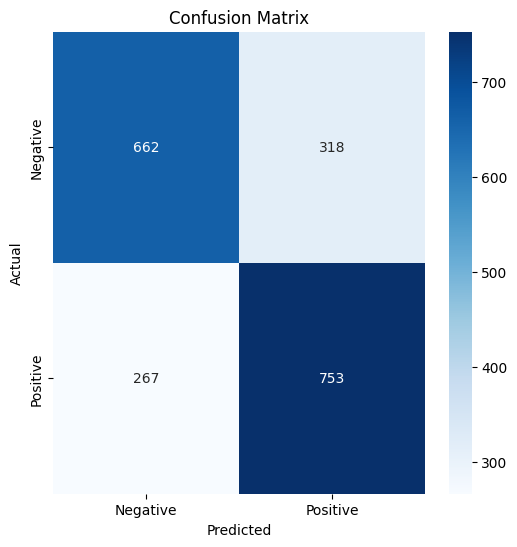

Tweet: I love this product! It's amazing!
Sentiment: Positive

Tweet: This is the worst experience ever.
Sentiment: Negative

Tweet: The service was okay, nothing special.
Sentiment: Negative

Tweet: I'm feeling very happy today!
Sentiment: Negative

Tweet: I hate when this happens.
Sentiment: Negative



In [10]:

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# %% [markdown]
# ## 7. Example Predictions

# %% [code]
# Test with custom tweets
test_tweets = [
    "I love this product! It's amazing!",
    "This is the worst experience ever.",
    "The service was okay, nothing special.",
    "I'm feeling very happy today!",
    "I hate when this happens."
]

for tweet in test_tweets:
    clean_tweet = preprocess_text(tweet)
    pred = pipeline.predict([clean_tweet])[0]
    sentiment = 'Positive' if pred == 1 else 'Negative'
    print(f"Tweet: {tweet}")
    print(f"Sentiment: {sentiment}\n")